In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [4]:
from scipy import signal

# Prep

In [5]:
import pathlib
outdir = pathlib.Path('output')

outdir.mkdir(exist_ok=True)

# Download and process data

In [35]:
levels = pd.read_csv('static/levels.csv', parse_dates=['date'])
shifts = pd.read_csv('static/shifts.csv', index_col='province')

In [5]:
cases_url = "data/covid19za_provincial_cumulative_timeline_confirmed.csv"
deaths_url = "data/covid19za_provincial_cumulative_timeline_deaths.csv"

In [24]:
provinces = ['EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC', 'SA']

In [7]:
province = 'GP'
outformat = 'png'
show_deathmodel = False
show_deathprediction = False

In [8]:
def read_source(url):
    df = pd.read_csv(url, parse_dates=['date'], index_col='date', dayfirst=True).rename(columns={'total': 'SA'})
    del df['YYYYMMDD']
    df = df[provinces] #.melt(var_name='province')
    return df

In [9]:
cases = read_source(cases_url)
deaths = read_source(deaths_url)

In [10]:
newcases = cases[province].diff()
newdeaths = deaths[province].diff()

## Predict the future from the past

In [11]:
import datetime

In [12]:
today = datetime.date.today()

In [37]:
startdate = shifts.loc[province, 'startdate']
shift = shifts.loc[province, 'shift']

In [15]:
shifted = newcases[startdate:].shift(shift*7, '1D')
shifted_rolling = shifted.rolling('7D').mean()

In [16]:
mappednewcases = shifted[today:]

In [17]:
combined = pd.DataFrame({'cases': pd.concat([newcases, mappednewcases]), 'deaths': newdeaths})['2020-06':]

# Simple delayed death model

In [18]:
ksize = 101

In [19]:
days = np.arange(1, ksize)

In [20]:
case_fatality = 0.025
shape = 4
scale = 5

In [21]:
pars = [case_fatality, shape, scale]

In [22]:
def kernel_func(case_fatality, shape, scale):
    return stats.distributions.gamma.pdf(days, shape, scale=scale)*case_fatality

In [23]:
def model(pars):
    case_fatality, shape, scale = pars
       
    kernel = np.zeros(ksize*2-1)

    kernel[ksize:] = kernel_func(case_fatality, shape, scale)
    
    prediction = signal.convolve(combined.cases, kernel, mode='same')
    
    return prediction

In [24]:
def plotmodel(case_fatality, shape, scale, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.title
    kernel = kernel_func(case_fatality, shape, scale)
    ax.plot(kernel)
    ax.set(
        xlabel='Days',
        ylabel='Chance of dying',
        title='Death model',
    )
    ax.text(scale, 0, f'Case fatality = {case_fatality:0.2%}')
#     ax.axvline(scale)

In [25]:
pars = [case_fatality, shape, scale]

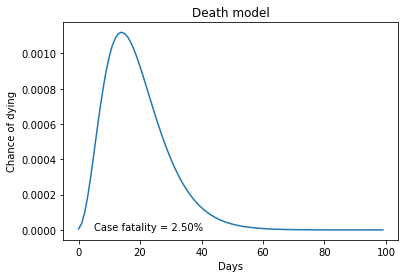

In [26]:
plotmodel(*pars)

In [27]:
prediction = model(pars)

In [28]:
kernel = kernel_func(*pars)

In [29]:
longprediction = signal.convolve(combined.cases, kernel)

In [30]:
combined['prediction'] = prediction

In [31]:
def error(pars):
    prediction = model(pars)
    combined['prediction'] = prediction
    return ((deaths[province] - combined['prediction'].cumsum())**2).sum()

In [32]:
from scipy.optimize import minimize

In [33]:
opt = minimize(error, pars, bounds=((0, 0.05), (1, 10), (1, 10)))

In [34]:
opt.x

array([ 0.0252373,  2.7892509, 10.       ])

In [35]:
prediction = model(opt.x)

In [36]:
combined['prediction'] = prediction

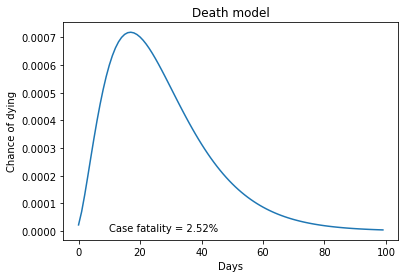

In [37]:
plotmodel(*opt.x)

<AxesSubplot:xlabel='date'>

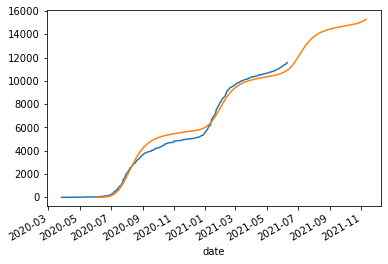

In [38]:
deaths[province].plot()
combined['prediction'].cumsum().plot()

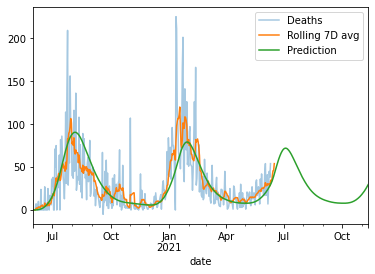

In [39]:
combined['deaths'].plot(alpha=0.4, label='Deaths')
combined['deaths'].rolling('7D').mean().plot(label='Rolling 7D avg')
combined['prediction'].plot(label='Prediction')
plt.legend()

In [40]:
peak_rate = newcases.max()
cutoff = 0.3

In [41]:
predicted_third_wave = (shifted_rolling[:'2021-06-15'] - peak_rate*cutoff).abs().idxmin()
predicted_third_wave

Timestamp('2021-05-26 00:00:00')

In [42]:
deathroll = '7D'

In [52]:
levels.append([''])

,date,level,comment
0,2020-03-15,0,State of disaster
1,2020-03-23,5,Lockdown
2,2020-05-01,4,NaN
3,2020-06-06,3,NaN
4,2020-08-17,2,NaN
5,2020-09-21,1,NaN
6,2020-12-29,3,NaN
7,2021-03-01,1,NaN
8,2021-05-31,2,NaN


In [53]:
from more_itertools import pairwise

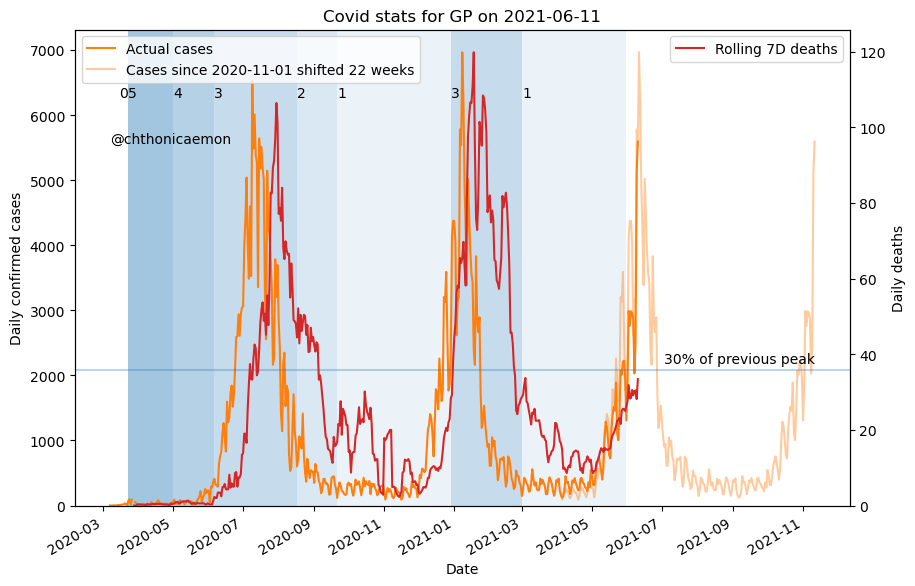

In [59]:
fig, ax_cases = plt.subplots(figsize=(10, 7), dpi=100)
ax_deaths = ax_cases.twinx()
# ax_deaths.spines['right'].set_edgecolor('C3')

for left, right in pairwise(levels.itertuples()):
    ax_cases.axvspan(left.date, right.date, alpha=left.level/12)
    ax_cases.annotate(left.level, (left.date, peak_rate*0.9))

newcases.plot(ax=ax_cases, color='C1', label='Actual cases')
shifted.plot(ax=ax_cases, color='C1', alpha=0.4, label=f'Cases since {startdate} shifted {shift} weeks')

newdeaths.rolling(deathroll).mean().plot(ax=ax_deaths, label=f'Rolling {deathroll} deaths', color='C3')
if show_deathprediction:
    combined['prediction'].plot(ax=ax_deaths, label="Death model", color='C3', style='--')
# newcases.rolling('7D').mean().plot()
ax_cases.axhline(peak_rate*cutoff, alpha=0.3)
# ax_cases.axvline(predicted_third_wave, alpha=0.3)
ax_cases.set(
    xlabel='Date',
    ylabel=f'Daily confirmed cases',
    title=f"Covid stats for {province} on {today}",
)
ax_cases.set_ylim(bottom=0)
ax_deaths.set_ylim(bottom=0)
ax_deaths.set(
    ylabel='Daily deaths'
)
ax_cases.legend(loc="upper left")
ax_deaths.legend(loc="upper right")
ax_cases.text(combined.index[-1], peak_rate*cutoff*1.05, f'{cutoff:.0%} of previous peak', horizontalalignment='right')
ax_cases.text(newcases.index[1], peak_rate*0.8, '@chthonicaemon')


# ax_cases.text(predicted_third_wave, 100, predicted_third_wave.date())
if show_deathmodel:
    ax_model = ax_cases.inset_axes([0.78, 0.65, 0.2, 0.2])
    plotmodel(*opt.x, ax_model)
plt.savefig(f'output/covid_{province}.{outformat}')

In [48]:
list(levels.itertuples())

[Pandas(Index=0, date=Timestamp('2020-03-15 00:00:00'), level=0, comment='State of disaster'),
 Pandas(Index=1, date=Timestamp('2020-03-23 00:00:00'), level=5, comment='Lockdown'),
 Pandas(Index=2, date=Timestamp('2020-05-01 00:00:00'), level=4, comment=nan),
 Pandas(Index=3, date=Timestamp('2020-06-06 00:00:00'), level=3, comment=nan),
 Pandas(Index=4, date=Timestamp('2020-08-17 00:00:00'), level=2, comment=nan),
 Pandas(Index=5, date=Timestamp('2020-09-21 00:00:00'), level=1, comment=nan),
 Pandas(Index=6, date=Timestamp('2020-12-29 00:00:00'), level=3, comment=nan),
 Pandas(Index=7, date=Timestamp('2021-03-01 00:00:00'), level=1, comment=nan),
 Pandas(Index=8, date=Timestamp('2021-05-31 00:00:00'), level=2, comment=nan)]